https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [3]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [4]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [5]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [6]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            # change here
            if m>f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [7]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [8]:
52+26*26+3

731

In [9]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 1.03 s, sys: 132 ms, total: 1.16 s
Wall time: 1.16 s


In [10]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [9]:
# name_count('abcdfaa')

In [10]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [11]:
pre1.shape

(49260, 4)

In [12]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [13]:
# pre0.head()

In [14]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
#     df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:2]
    df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 749)
CPU times: user 602 ms, sys: 55 ms, total: 657 ms
Wall time: 652 ms


In [15]:
pd.options.display.max_columns=100
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [16]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [17]:
# pre0.to_csv('./preprocessed.csv', index=False)

In [18]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [19]:
# print pre0.columns.values
print pre0.columns.values[2:8]
pre0.head()

['username_split_predict' 'last' 'last_two' 'first' 'first2' 'first3']


,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [20]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [21]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:9]
label_encode(pre0, to_be_encoded_cols)

# pre0 =pre0.drop(['username_split_predict'], axis=1)

CPU times: user 128 ms, sys: 1 ms, total: 129 ms
Wall time: 129 ms


In [22]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1], 
                                                  random_state=7)
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 747), (34482,), (14778, 747), (14778,)]


,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
1046,1,40,1678,8,346,1470,6,0.222222,0.0,True,False,False,False,0,4,True,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,9.0


In [23]:
# pre0.to_csv('preprocessed.csv',index=False)

In [24]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [25]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.33 s, sys: 297 ms, total: 3.62 s
Wall time: 3.62 s


0.819935038571
0.8215590743
Confusion matrix, without normalization
[[  443  2218]
 [  419 11698]]


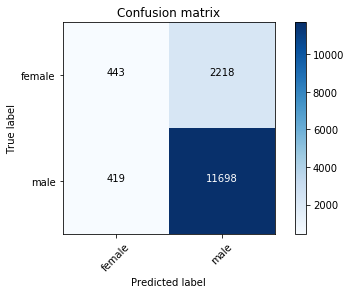

In [26]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [27]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 50.9 s, sys: 976 ms, total: 51.9 s
Wall time: 4.34 s


0.819935038571
0.831573961294
Confusion matrix, without normalization
[[  190  2471]
 [   18 12099]]


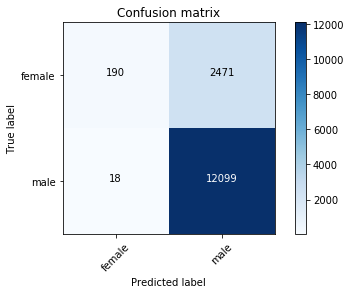

In [28]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [29]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=4, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 36s, sys: 1.09 s, total: 3min 37s
Wall time: 11.9 s


0.819935038571
0.831844633915
Confusion matrix, without normalization
[[  192  2469]
 [   16 12101]]


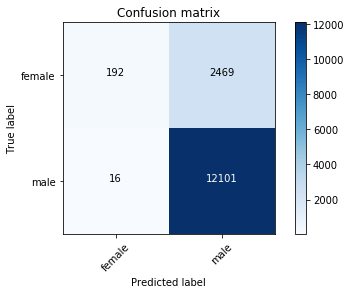

In [30]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [31]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

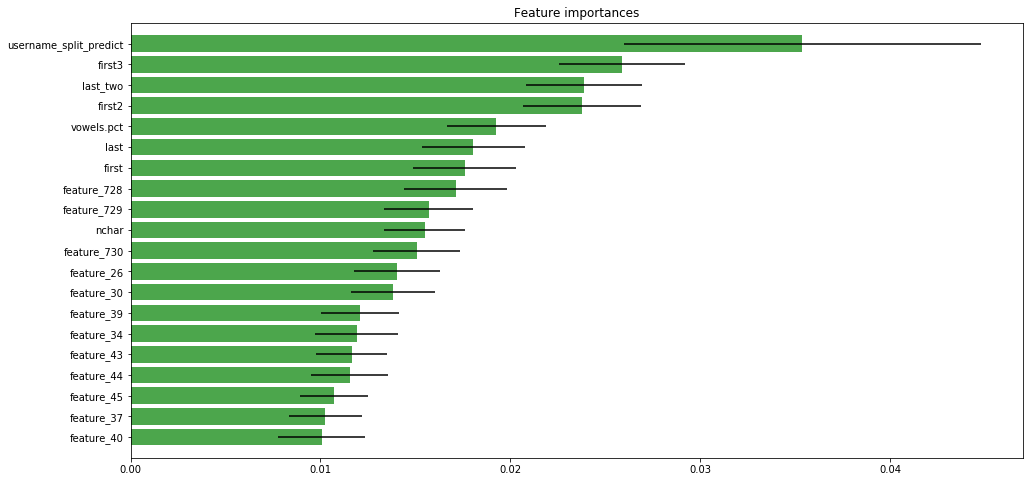

Feature ranking:
1. feature username_split_predict (3.54 %)
2. feature first3 (2.59 %)
3. feature last_two (2.39 %)
4. feature first2 (2.38 %)
5. feature vowels.pct (1.93 %)
6. feature last (1.80 %)
7. feature first (1.76 %)
8. feature feature_728 (1.71 %)
9. feature feature_729 (1.57 %)
10. feature nchar (1.55 %)
11. feature feature_730 (1.51 %)
12. feature feature_26 (1.40 %)
13. feature feature_30 (1.38 %)
14. feature feature_39 (1.21 %)
15. feature feature_34 (1.19 %)
16. feature feature_43 (1.16 %)
17. feature feature_44 (1.15 %)
18. feature feature_45 (1.07 %)
19. feature feature_37 (1.03 %)
20. feature feature_40 (1.01 %)
21. feature digits.pct (0.99 %)
22. feature feature_38 (0.91 %)
23. feature feature_28 (0.91 %)
24. feature feature_29 (0.77 %)
25. feature feature_33 (0.77 %)
26. feature feature_0 (0.75 %)
27. feature digits.num (0.72 %)
28. feature feature_4 (0.72 %)
29. feature feature_46 (0.69 %)
30. feature feature_27 (0.69 %)
31. feature feature_32 (0.67 %)
32. feature f

In [32]:
plotting(fr, X_train, 20)

In [33]:
# RandomForestClassifier?

In [34]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 350 ms, total: 1min 3s
Wall time: 5.07 s


0.819935038571
0.830829611585
Confusion matrix, without normalization
[[  182  2479]
 [   21 12096]]


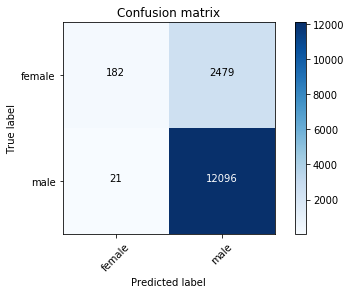

In [35]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.820070374882
Confusion matrix, without normalization
[[    8  2653]
 [    6 12111]]


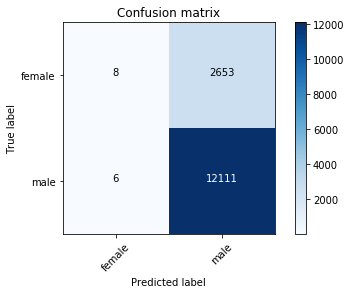

CPU times: user 8.71 s, sys: 2.54 s, total: 11.3 s
Wall time: 8.52 s


In [36]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [14]:
import xgboost as xgb

In [15]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

NameError: name 'X_train' is not defined

In [13]:
d_train.get_label()

NameError: name 'd_train' is not defined

In [40]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [41]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [42]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.854069	test-acc:0.795371
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.867467	test-acc:0.828664
[40]	train-acc:0.881735	test-acc:0.830897
[60]	train-acc:0.899165	test-acc:0.832251
[80]	train-acc:0.920016	test-acc:0.833536
[100]	train-acc:0.940578	test-acc:0.833604
[120]	train-acc:0.956267	test-acc:0.834281
[140]	train-acc:0.967577	test-acc:0.834078
[160]	train-acc:0.977496	test-acc:0.834213
[180]	train-acc:0.98463	test-acc:0.835296
[200]	train-acc:0.989589	test-acc:0.835499
[220]	train-acc:0.993011	test-acc:0.835634
[240]	train-acc:0.995476	test-acc:0.835566
[260]	train-acc:0.9971	test-acc:0.835566
[280]	train-acc:0.998347	test-acc:0.835837
[300]	train-acc:0.999072	test-acc:0.835634
[320]	train-acc:0.999478	test-acc:0.835905
[340]	train-acc:0.999681	test-acc:0.835837
[360]	train-acc:0.999826	test-acc:0.835363
[380]	train-acc:0.999826	test-acc:0.835634
Stoppin

'!!! used 84.32 s'

accuracy 0.835634050616
statistic
male      14160
female      618
dtype: int64
Confusion matrix, without normalization
[[  425  2236]
 [  193 11924]]


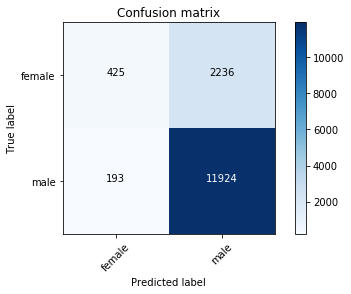

In [43]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [44]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [45]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [46]:
6210.0/28272

0.21965195246179967

In [47]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [16]:
xgb.train?

In [48]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.83777	test-acc:0.821356
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 200 rounds.
[20]	train-acc:0.84592	test-acc:0.826567
[40]	train-acc:0.847167	test-acc:0.826634
[60]	train-acc:0.846616	test-acc:0.826567
[80]	train-acc:0.848182	test-acc:0.82677
[100]	train-acc:0.849574	test-acc:0.826905
[120]	train-acc:0.850908	test-acc:0.828258
[140]	train-acc:0.852068	test-acc:0.828394
[160]	train-acc:0.854504	test-acc:0.828732
[180]	train-acc:0.856215	test-acc:0.828935
[200]	train-acc:0.857317	test-acc:0.829612
[220]	train-acc:0.859115	test-acc:0.830288
[240]	train-acc:0.860246	test-acc:0.829815
[260]	train-acc:0.861551	test-acc:0.829679
[280]	train-acc:0.862914	test-acc:0.829815
[300]	train-acc:0.864451	test-acc:0.830221
[320]	train-acc:0.866336	test-acc:0.830491
[340]	train-acc:0.868308	test-acc:0.82995
[360]	train-acc:0.870512	test-acc:0.830153
[380]	train-acc:0.873412	test-acc:0.830288
[400]	tr

'!!! used 287.69 s'

accuracy 0.835092705373
statistic
male      14202
female      576
dtype: int64
Confusion matrix, without normalization
[[  400  2261]
 [  176 11941]]


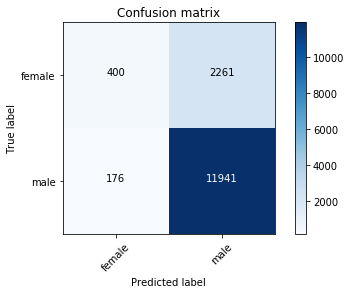

In [49]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [50]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
140,last_two,48324
280,first2,36843
362,vowels.pct,36746
281,first3,29102
425,last,28996
428,nchar,21125
516,feature_728,21009
515,feature_729,20481
527,feature_30,19978
53,feature_26,19733


In [51]:
# pd.DataFrame.plot?

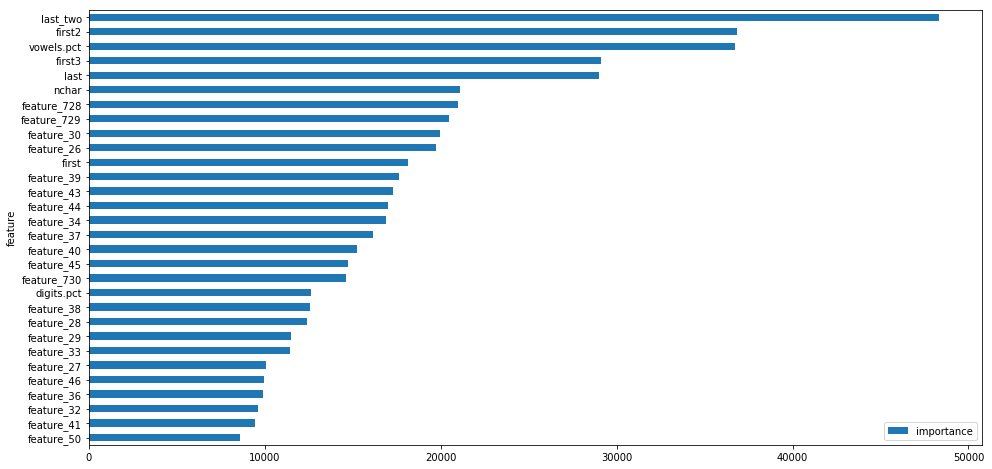

In [52]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [53]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman


### other sklearn models

In [54]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [55]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [56]:
# svm = SVC()
# svm

In [57]:
# %%time
# # svm.fit(X_train, y_train)

In [58]:
# from sklearn.neural_network import MLPClassifier

In [59]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [60]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [61]:
# pd.Series(neur_prd).value_counts()

In [62]:
# accuracy_score(y_test,neur_prd)

In [63]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [64]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [65]:
# pd.Series(pred).value_counts()

In [66]:
# accuracy_score(y_test, pred)

In [67]:
# confusion_matrix(y_test,pred)

In [68]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [69]:
# from sklearn.naive_bayes import BernoulliNB

In [70]:
# nb = BernoulliNB()
# nb

In [71]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()